In [27]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.stats as ss
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw

import networkx as nx

from utils.graph_utils import *
from dataset.preprocess import *
from predict_logp.predict_logp import *
import torch_geometric as pyg

In [11]:
def compute_baseline_error(scores):
    mean = scores.mean()
    sq_sum = np.sum(np.square(scores - mean)) / len(scores)
    return sq_sum

In [2]:
def read_data(dataset_path):
    all_logp = []
    all_smiles = []
    with open(dataset_path, newline='') as csvfile:
        reader = csv.reader(csvfile)

        for i, (logp, smiles) in enumerate(reader):
            # Some fields are empty, if logp is empty it will be caught by the exception. If smile is empty, conditional kicks in.
            try:
                if smiles is not None:
                    all_logp.append(float(logp))
                    all_smiles.append(smiles)
                else:
                    continue
            except:
                print("Row " + str(i) + "was not read.")
                continue
    return all_logp, all_smiles

In [17]:
scores, smiles = read_data("/Users/ADChen/Downloads/MD/2col/NPRBD_6VYO_A_1_F.Orderable_zinc_db_enaHLL.2col.csv")

In [18]:
train_data, valid_data, test_data = create_datasets(scores, smiles)
test_labels = np.array(test_data.logp)

In [19]:
sort_idx = np.argsort(test_labels)
test_labels_sorted = test_labels[sort_idx]


In [20]:
test_labels_sorted

array([-11.57715 , -11.259275, -11.258567, ...,   1.017367,   1.017367,
         1.017367])

In [21]:
compute_baseline_error(test_labels)

1.02446528114315

In [22]:
int(len(test_labels)//20)

61013

In [24]:
test_labels[61013]

-5.492459

In [6]:
sum(test_labels<-11)

102717

In [88]:
# For weighted sampling 
def dock_score_weights(scores):                        
    weights = np.zeros(len(scores))                                          
    for idx, score in enumerate(scores):
        if score < -6:
            weight = 1
        else:
            weight = 0.1
        weights[idx] = weight                               
    return weights      

In [89]:
len(test_labels)

1166893

In [90]:
from scipy.stats import pearsonr
def tail_corr(a, b):
    assert len(a) == len(b)
    tail_corr = np.array([pearsonr(a[:i], b[:i])[0] for i in np.arange(30, len(a))], dtype=float)
    tail_corr = np.insert(tail_corr, 0, np.repeat(np.nan, 30))
    return tail_corr

In [91]:
_ = np.arange(1e6)

In [92]:
_noise = _ + np.random.randn(int(1e6))

In [93]:
tail_corr(_, _noise)

KeyboardInterrupt: 

# Custom Loss functions

In [168]:
def exp_weighted_mse(output, target):
    loss = torch.mean(torch.exp(-0.4*(target+5))*(output - target)**2)
    return loss

model = torch.nn.Linear(2, 2)
x = torch.randn(1, 2)
target = torch.randn(1, 2)
output = model(x)
loss = exp_weighted_mse(output, target)
loss.backward()
print(model.weight.grad)

tensor([[-0.3276, -1.2283],
        [ 0.0085,  0.0320]])


In [174]:
criterion(output,target)

tensor(0.6595, grad_fn=<MeanBackward0>)

In [173]:
criterion = exp_weighted_mse

In [169]:
output

tensor([[ 0.1011, -0.2856]], grad_fn=<AddmmBackward>)

In [170]:
model.weight

Parameter containing:
tensor([[-0.1056, -0.2275],
        [ 0.6924, -0.0929]], requires_grad=True)

In [171]:
model.bias

Parameter containing:
tensor([-0.3982, -0.1065], requires_grad=True)

# Histograms

Want to explore parameter space of exponential weighting and just upsampling. 
- Try plotting different random exponentials on distribution of scores.
- Figure out how to do explore upsampling

In [90]:
global _abc

In [84]:
np.percentile(np.arange(10), 25)

2.25

In [82]:
np.random.uniform(0.5,1,1)[0]

0.8281952972559741

In [75]:
np.exp(-(x-min(test_labels))/4)/4

array([0.25      , 0.24217403, 0.23459303, 0.22724936, 0.22013557,
       0.21324447, 0.20656908, 0.20010267, 0.19383867, 0.18777077,
       0.18189281, 0.17619886, 0.17068315, 0.1653401 , 0.16016431,
       0.15515054, 0.15029372, 0.14558895, 0.14103144, 0.13661661,
       0.13233998, 0.12819722, 0.12418415, 0.1202967 , 0.11653094,
       0.11288307, 0.10934939, 0.10592633, 0.10261042, 0.09939832,
       0.09628676, 0.09327261, 0.09035281, 0.08752442, 0.08478456,
       0.08213048, 0.07955947, 0.07706895, 0.07465639, 0.07231936,
       0.07005548, 0.06786247, 0.06573811, 0.06368025, 0.06168681,
       0.05975577, 0.05788518, 0.05607315, 0.05431784, 0.05261748,
       0.05097035, 0.04937478, 0.04782916, 0.04633192, 0.04488155,
       0.04347658, 0.0421156 , 0.04079721, 0.0395201 , 0.03828297,
       0.03708456, 0.03592367, 0.03479912, 0.03370977, 0.03265452,
       0.03163231, 0.0306421 , 0.02968288, 0.02875369, 0.02785359,
       0.02698166, 0.02613703, 0.02531884, 0.02452626, 0.02375

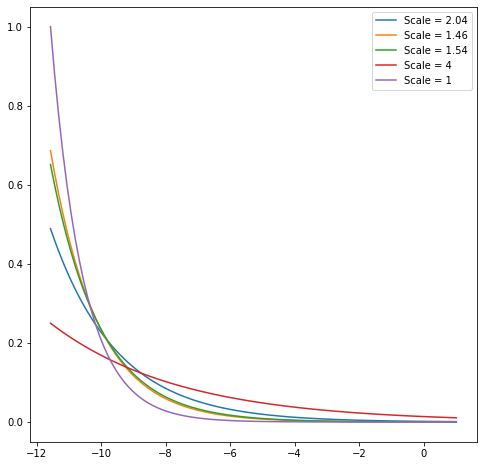

In [68]:
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111)
rv_max = ss.expon(loc = min(test_labels), scale = 4)
rv_min = ss.expon(loc = min(test_labels), scale = 1)
x = np.linspace(min(test_labels),max(test_labels),100)
for i in np.random.uniform(1,4,3):
    ax.plot(x, ss.expon(loc = min(test_labels), scale = i).pdf(x), label = "Scale = " + str(round(i,2)))
ax.plot(x, rv_max.pdf(x), label = "Scale = 4")
ax.plot(x, rv_min.pdf(x), label = "Scale = 1");
ax.legend()

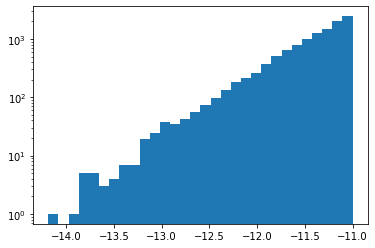

In [10]:
plt.hist(test_labels[test_labels<-11], bins = 30, log=True);

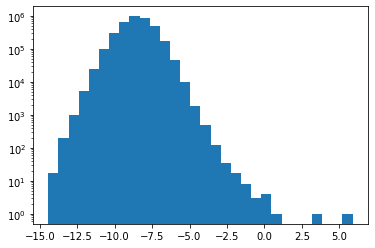

In [15]:
train_labels = np.array(train_data.logp)
plt.hist(train_labels, bins = 30, log=True);

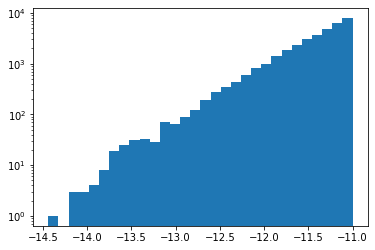

In [16]:
plt.hist(train_labels[train_labels < -11], bins = 30, log=True);